### Load in Shot Data

In [1]:
import pickle

%store -r shots

df = shots['df']
sideways = df.T

### Plotting Functions

In [2]:
def draw_goal(axes):
    """Draw a goal on the axes"""
    
    X_GOAL = 3
    
    axes.plot((X_GOAL, X_GOAL), (-1.5, 1.5), 'k-', linewidth=2.)
    axes.plot((X_GOAL-.1, X_GOAL), (1.5, 1.5), 'k-', linewidth=2.)
    axes.plot((X_GOAL-.1, X_GOAL), (-1.5, -1.5), 'k-', linewidth=2.)
    axes.annotate('Goal', xy=(X_GOAL, 1.5), xytext=(4, 2.5), arrowprops=dict(facecolor='black', shrink=0.05, width=1.))
    
    return axes

In [3]:
def plot_confusion_matrix(confusion_matrices, clf):
    columns = ('Wide Left', 'Shot Left', 'Shot Middle', 'Shot Right', 'Wide Right', 'Short')
    num = len(confusion_matrices)
    fars, nears = ['Far']*num, ['Near']*num
    distances = fars + nears
    distances[::2], distances[1::2] = fars, nears
    
    feature_sets = ['Position+Velocity']*2 + ['Position']*2 + ['Distance+Bearing']*2
    
    fig = plt.figure(figsize=(30,30))
    plt.clf()

    for subplot_num, confusion_matrix, distance, features in zip((2, 3, 5, 6, 8, 9), confusion_matrices, distances, feature_sets):
        axes = fig.add_subplot(3, 3, subplot_num)
        df = pd.DataFrame(confusion_matrix, columns=columns, index=columns)
        axes.imshow(df, interpolation='nearest')
        plt.title('{} {} ({})'.format(clf, features, distance))
        tick_marks = np.arange(len(columns))
        plt.xticks(tick_marks, df.index, rotation=90)
        plt.yticks(tick_marks, df.index)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

        width = height = len(columns)

        for x in xrange(width):
            for y in xrange(height):
                axes.annotate(str(confusion_matrix[x][y]) if confusion_matrix[x][y] else '', xy=(y, x), 
                            horizontalalignment='center',
                            verticalalignment='center')

    fig.subplots_adjust(wspace=.35, hspace=.65)
    
    return fig

### Original Keeper Behavior

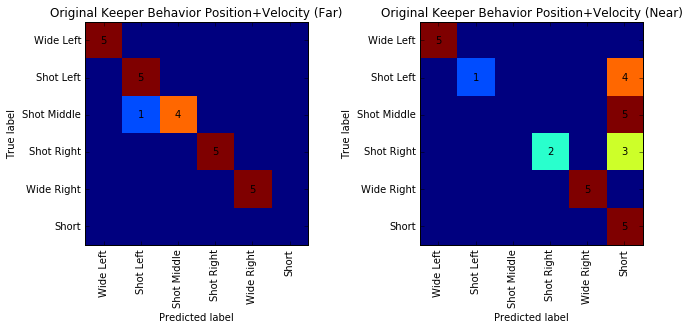

In [6]:
far = np.array([[5,0,0,0,0,0],
                [0,5,0,0,0,0],
                [0,1,4,0,0,0],
                [0,0,0,5,0,0],
                [0,0,0,0,5,0],
                [0,0,0,0,0,0]])

near = np.array([[5,0,0,0,0,0],
                 [0,1,0,0,0,4],
                 [0,0,0,0,0,5],
                 [0,0,0,2,0,3],
                 [0,0,0,0,5,0],
                 [0,0,0,0,0,5]])

plot_confusion_matrix([far, near], 'Original Keeper Behavior')

### Softmax

In [4]:
pv_far =  np.array([[0,0,5,0,0,0],
                    [0,0,5,0,0,0],
                    [0,0,4,1,0,0],
                    [0,0,1,4,0,0],
                    [0,0,0,5,0,0],
                    [0,0,0,0,0,0]])

pv_near = np.array([[0,0,5,0,0,0],
                    [0,0,5,0,0,0],
                    [0,0,4,1,0,0],
                    [0,0,1,4,0,0],
                    [0,0,0,5,0,0],
                    [0,0,5,0,0,0]])

p_far  =  np.array([[1,4,0,0,0,0],
                    [0,5,0,0,0,0],
                    [0,0,4,1,0,0],
                    [0,0,0,5,0,0],
                    [0,0,0,5,0,0],
                    [0,0,0,0,0,0]])

p_near =  np.array([[4,1,0,0,0,0],
                    [0,5,0,0,0,0],
                    [0,0,5,0,0,0],
                    [0,0,0,5,0,0],
                    [0,0,0,4,1,0],
                    [0,0,0,0,0,5]])

db_far =  np.array([[4,1,0,0,0,0],
                    [0,2,3,0,0,0],
                    [0,0,5,0,0,0],
                    [0,0,0,5,0,0],
                    [0,0,0,5,0,0],
                    [0,0,0,0,0,0]])

db_near = np.array([[0,0,5,0,0,0],
                    [0,0,5,0,0,0],
                    [0,0,5,0,0,0],
                    [0,0,5,0,0,0],
                    [0,0,5,0,0,0],
                    [0,0,5,0,0,0]])

%matplotlib qt
fig = plot_confusion_matrix([pv_far, pv_near, p_far, p_near, db_far, db_near], 'Softmax')

# Position+Velocity
axes = fig.add_subplot(3, 3, 1)
with open('/home/ebanner/nao/trunk/core/python/behaviors/position_velocity-softmax.py', 'rb') as f:
    model = pickle.load(f)

# Load in softmax and make predictions
sm = model['clf']
X = np.array(sideways.ix[['x0', 'y0', 'dx0', 'dy0']]).astype(float)
scores, predictions = sm.predict(X)
df['predictions'] = predictions

# Plot decisions
colormap = np.array(['r', 'g', 'b', 'y'])
axes = df.plot(ax=axes, kind='scatter', x='x0', y='y0', c=colormap[df['predictions']], title='Softmax Decision Boundaries', s=0)
axes.quiver(df['x0'], df['y0'], df['dx0'], df['dy0'], color=colormap[df['predictions']], scale_units='xy', angles='xy', scale=2.5, width=.0022)
draw_goal(axes)

# Position
axes = fig.add_subplot(3, 3, 4)
with open('/home/ebanner/nao/trunk/core/python/behaviors/position-softmax.py', 'rb') as f:
    model = pickle.load(f)

# Load in softmax and make predictions
sm = model['clf']
X = np.array(sideways['x0':'y{}'.format(model['window_size']-1)]).astype(float)
scores, predictions = sm.predict(X)
df['predictions'] = predictions

# Plot decisions
scores, predictions = sm.predict(X)
df['predictions'] = predictions
axes = df.plot(ax=axes, kind='scatter', x='x_avg', y='y_avg', c=colormap[df['predictions']], title='Softmax Decision Boundaries', s=0)
axes.quiver(df['x_avg'], df['y_avg'], df['dx_avg'], df['dy_avg'], color=colormap[df['predictions']], scale_units='xy', angles='xy', scale=2.5, width=.0022)
draw_goal(axes)

# Distance+Bearing
axes = fig.add_subplot(3, 3, 7)
with open('/home/ebanner/nao/trunk/core/python/behaviors/distance_bearing-softmax.py', 'rb') as f:
    model = pickle.load(f)

# Load in softmax and make predictions
sm = model['clf']
X = np.array(sideways['dist0':'theta{}'.format(model['window_size']-1)])
scores, predictions = sm.predict(X)
df['predictions'] = predictions

# Plot decisions
scores, predictions = sm.predict(X)
df['predictions'] = predictions
axes = df.plot(ax=axes, kind='scatter', x='x_avg', y='y_avg', c=colormap[df['predictions']], title='Softmax Decision Boundaries', s=0)
axes.quiver(df['x_avg'], df['y_avg'], df['dx_avg'], df['dy_avg'], color=colormap[df['predictions']], scale_units='xy', angles='xy', scale=2.5, width=.0022)
draw_goal(axes)

In [5]:
import os

os.environ['PYTHONPATH']

':/home/ebanner/cs393r_project/classifiers:/home/ebanner/cs393r_project/classifiers/lib:/home/ebanner/project/classifiers:/home/ebanner/project/classifiers/lib:/home/ebanner/project/classifiers:/home/ebanner/project/classifiers/lib'

### Neural Network 

In [5]:
pv_far =  np.array([[3,2,1,0,0,0],
                    [0,3,2,0,0,0],
                    [0,0,5,0,0,0],
                    [0,0,5,0,0,0],
                    [0,0,0,5,0,0],
                    [0,0,0,0,0,0]])

pv_near = np.array([[5,0,0,0,0,0],
                    [0,1,4,0,0,0],
                    [0,0,5,0,0,0],
                    [0,0,1,4,0,0],
                    [0,0,5,0,0,0],
                    [0,0,5,0,0,0]])

p_far  =  np.array([[0,5,0,0,0,0],
                    [0,5,0,0,0,0],
                    [0,0,5,0,0,0],
                    [0,0,0,5,0,0],
                    [0,0,0,1,4,0],
                    [0,0,0,0,0,0]])

p_near =  np.array([[0,5,0,0,0,0],
                    [0,1,4,0,0,0],
                    [0,0,5,0,0,0],
                    [0,0,0,5,0,0],
                    [0,0,0,0,5,0],
                    [0,0,2,0,0,3]])

db_far =  np.array([[5,0,0,0,0,0],
                    [0,2,3,0,0,0],
                    [0,0,5,0,0,0],
                    [0,0,0,5,0,0],
                    [0,0,0,0,5,0],
                    [0,0,0,0,0,0]])

db_near = np.array([[0,0,5,0,0,0],
                    [0,1,2,0,0,2],
                    [0,0,5,0,0,0],
                    [0,0,0,5,0,0],
                    [0,0,5,0,0,0],
                    [0,0,0,0,0,5]])

%matplotlib qt
fig = plot_confusion_matrix([pv_far, pv_near, p_far, p_near, db_far, db_near], 'Neural Network')

colormap = np.array(['r', 'g', 'b', 'y'])

# Position+Velocity
axes = fig.add_subplot(3, 3, 1)
with open('/home/ebanner/nao/trunk/core/python/behaviors/position_velocity-nn.py', 'rb') as f:
    model = pickle.load(f)

# Load in nn and make predictions
nn = model['clf']
X = np.array(sideways.ix[['x0', 'y0', 'dx0', 'dy0']]).astype(float)
scores, predictions = nn.predict(X)
df['predictions'] = predictions
axes = df.plot(ax=axes, kind='scatter', x='x0', y='y0', c=colormap[df['predictions']], title='Neural Network Decision Boundaries', s=0)
axes.quiver(df['x0'], df['y0'], df['dx0'], df['dy0'], color=colormap[df['predictions']], scale_units='xy', angles='xy', scale=2.5, width=.0022)
draw_goal(axes)

# Position
axes = fig.add_subplot(3, 3, 4)
with open('/home/ebanner/nao/trunk/core/python/behaviors/positions-nn.py', 'rb') as f:
    model = pickle.load(f)

# Load in nn and make predictions
nn = model['clf']
X = np.array(sideways['x0':'y{}'.format(model['window_size']-1)]).astype(float)
scores, predictions = nn.predict(X)
df['predictions'] = predictions
axes = df.plot(ax=axes, kind='scatter', x='x_avg', y='y_avg', c=colormap[df['predictions']], title='Neural Network Decision Boundaries', s=0)
axes.quiver(df['x_avg'], df['y_avg'], df['dx_avg'], df['dy_avg'], color=colormap[df['predictions']], scale_units='xy', angles='xy', scale=2.5, width=.0022)
draw_goal(axes)

# Distance+Bearing
axes = fig.add_subplot(3, 3, 7)
with open('/home/ebanner/nao/trunk/core/python/behaviors/distance_bearing-nn.py', 'rb') as f:
    model = pickle.load(f)

# Load in nn and make predictions
nn = model['clf']
X = np.array(sideways['dist0':'theta{}'.format(model['window_size']-1)])
scores, predictions = nn.predict(X)
df['predictions'] = predictions
axes = df.plot(ax=axes, kind='scatter', x='x_avg', y='y_avg', c=colormap[df['predictions']], title='Neural Network Decision Boundaries', s=0)
axes.quiver(df['x_avg'], df['y_avg'], df['dx_avg'], df['dy_avg'], color=colormap[df['predictions']], scale_units='xy', angles='xy', scale=2.5, width=.0022)
draw_goal(axes)